In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , tam , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size=tam )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df, a, b ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( a , b ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .8 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 17 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

In [3]:
def preprocess_features(X):
    ''' Pré-processa os dados dos estudantes e converte as variáveis binárias não numéricas em
        variáveis binárias (0/1). Converte variáveis categóricas em variáveis postiças. '''
    
    # Inicialize nova saída DataFrame
    output = pd.DataFrame(index = X.index)

    # Observe os dados em cada coluna de atributos 
    for col, col_data in X.iteritems():
        
        # Se o tipo de dado for não numérico, substitua todos os valores yes/no por 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # Se o tipo de dado for categórico, converta-o para uma variável dummy
        #if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            #col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Reúna as colunas revisadas
        output = output.join(col_data)
    
    return output


In [8]:
# Ler os dados dos estudantes
student_data = pd.read_csv("student-data.csv")
print "Os dados dos estudantes foram lidos com êxito!"

print  list(student_data.columns)

Os dados dos estudantes foram lidos com êxito!
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'passed']


In [5]:
s_d = student_data 

s_d = preprocess_features(s_d)
print "Processed feature columns ({} total features):\n{}".format(len(s_d.columns), list(s_d.columns))

s_d.head()

Processed feature columns (31 total features):
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'passed']


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,0,0,4,3,4,1,1,3,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,0,5,3,3,1,1,3,4,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,1,0,4,3,2,2,3,3,10,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,1,1,3,2,2,1,1,5,2,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,0,0,4,3,2,1,2,5,4,1


In [6]:
s_d.describe()

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,0.129114,0.612658,0.458228,0.508861,...,0.832911,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,0.670886
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.335751,0.487761,0.498884,0.500555,...,0.373528,0.472300,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,0.470487
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,1.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,1.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,1.000000


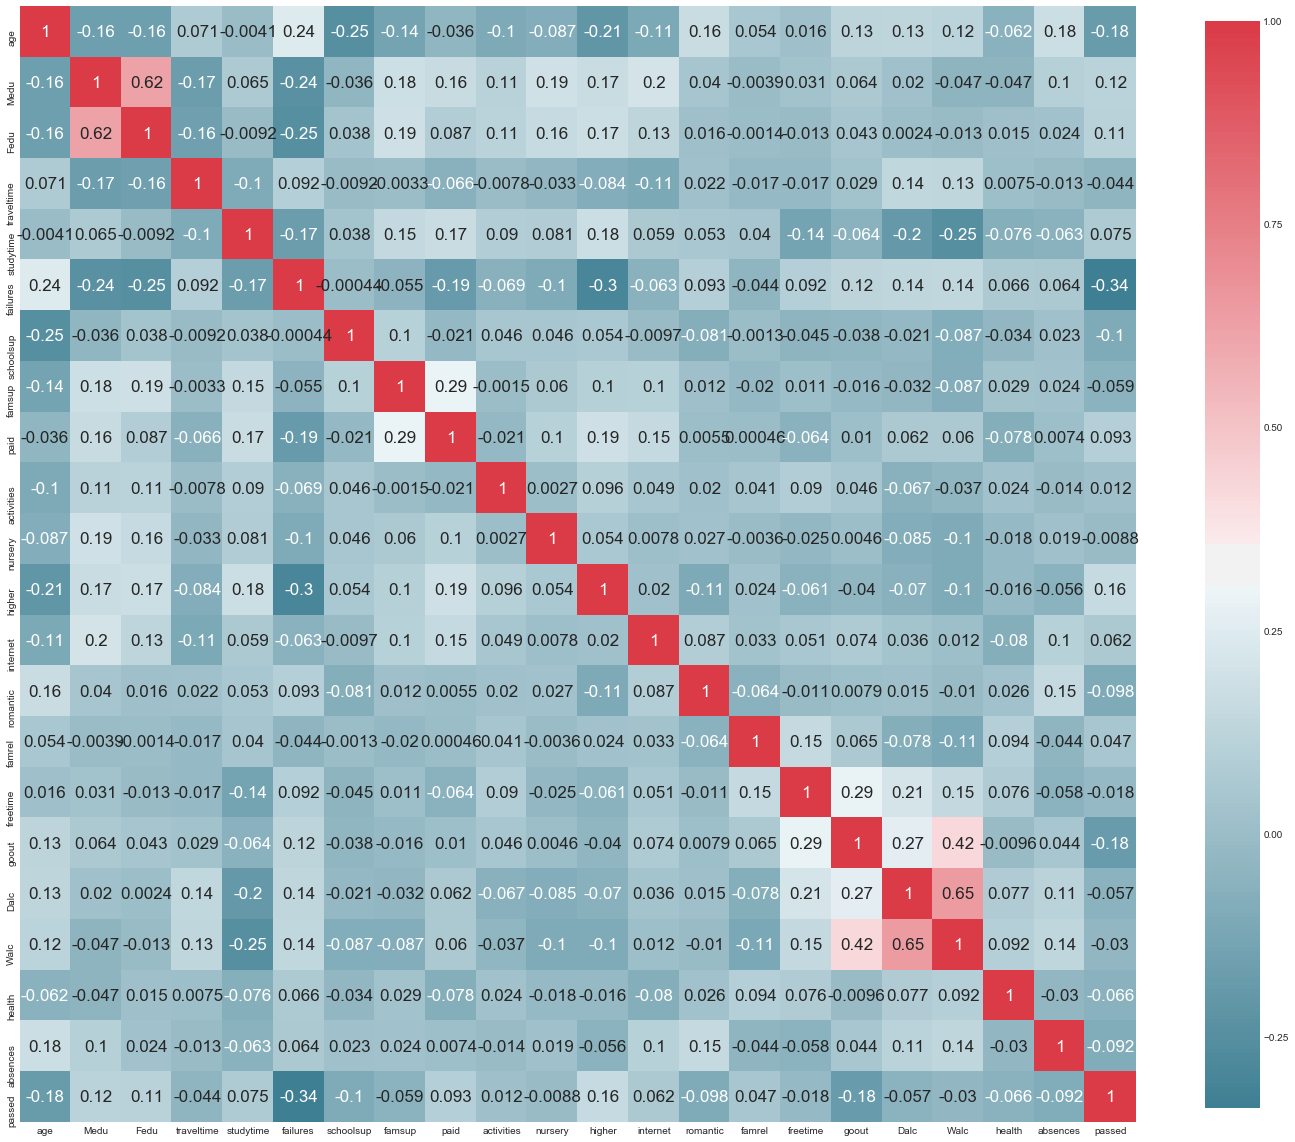

In [7]:
plot_correlation_map( s_d, 25 , 25)

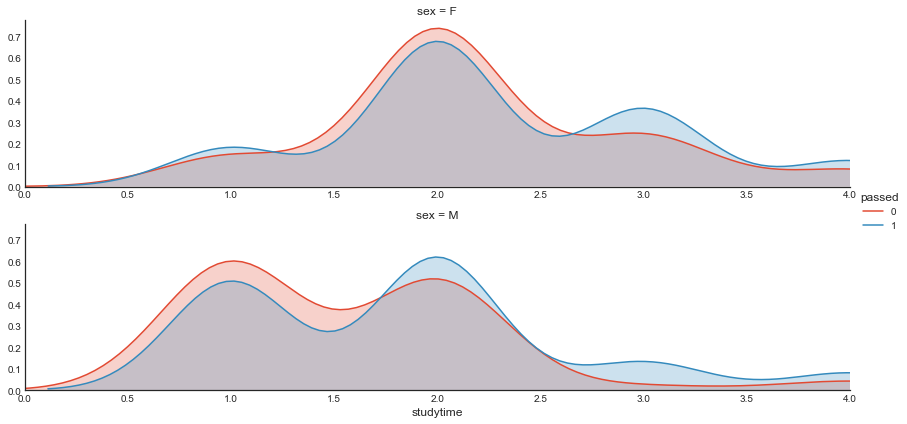

In [12]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( s_d , var = 'studytime' , target = 'passed' , row = 'sex' )

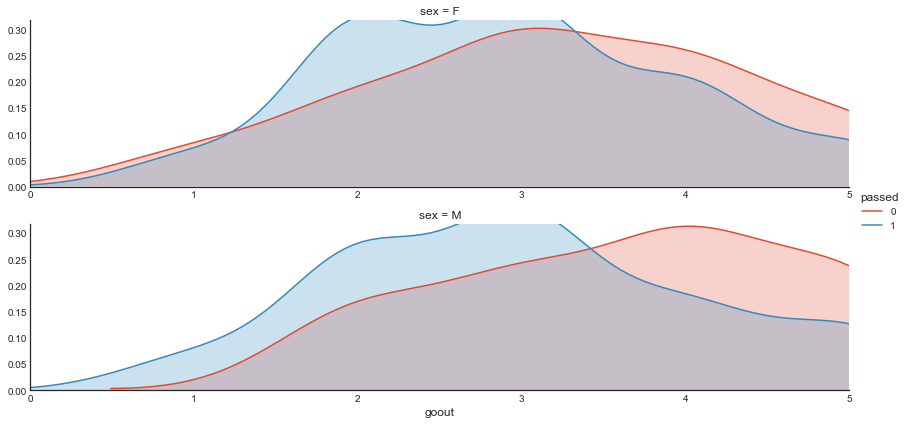

In [15]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( s_d , var = 'goout' , target = 'passed' , row = 'sex' )

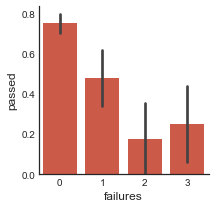

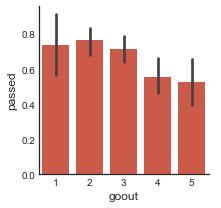

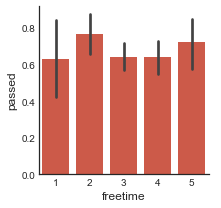

In [33]:
plot_categories( s_d , cat = 'failures' , target = 'passed', tam = 3 )
plot_categories( s_d , cat = 'goout' , target = 'passed', tam = 3 )
plot_categories( s_d , cat = 'freetime' , target = 'passed', tam = 3 )